In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter


import csv
import pandas as pd



In [2]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #fig1 = plt.figure()
    #plt.plot(time, x[0,0,:])
    #plt.show()
    #fig1.savefig(f'CLASS:{CLASS}, iteration: {it}')
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
   
    X_data_class_1_domain_1 = np.empty((0,1,window_size))
    X_data_class_2_domain_1 = np.empty((0,1,window_size))
    X_data_class_1_domain_2 = np.empty((0,1,window_size))
    X_data_class_2_domain_2 = np.empty((0,1,window_size))
    
    for i in range(n):
        X_data_class_1_domain_1 = np.append(X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size), axis = 0) 
        X_data_class_2_domain_1 = np.append(X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_1_domain_2 = np.append(X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_2_domain_2 = np.append(X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size), axis = 0)
        
        #print(i)
        #print((X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [3]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 8000
        frequencies = [1,4,1.9,3.1]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [4]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
ce_size_source = int(0.2 * len(dataset_source))
validation_size_source = int(0.2 * len(dataset_source))
mmd_size_source = int(0.6 * len(dataset_source))


ce_dataset_source, validation_dataset_source, mmd_dataset_source = torch.utils.data.random_split(dataset_source, [ce_size_source, validation_size_source, mmd_size_source])
batch_size = 64
ce_loader_source = DataLoader(dataset=ce_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
mmd_loader_source = DataLoader(dataset=mmd_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)






dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
ce_size_target = int(0.2 * len(dataset_target))
validation_size_target = int(0.2 * len(dataset_target))
mmd_size_target = int(0.6 * len(dataset_target))

ce_dataset_target, validation_dataset_target, mmd_dataset_target = torch.utils.data.random_split(dataset_target, [ce_size_target, validation_size_target, mmd_size_target])
batch_size = 64
ce_loader_target = DataLoader(dataset=ce_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
mmd_loader_target = DataLoader(dataset=mmd_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)



source_loader = {}
source_loader["ce"] = ce_loader_source
source_loader["val"] = validation_loader_source
source_loader["mmd"] = mmd_loader_target

target_loader = {}
target_loader["ce"] = ce_loader_target
target_loader["val"] = validation_loader_target
target_loader["mmd"] = mmd_loader_target

In [11]:
class CNN(nn.Module):
    def __init__(self, input_size, input_fc_size, hidden_fc_size_1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: ((1000+2*0-(100-1)-1)/1)+1 = 901
        self.pool1 = nn.MaxPool1d(4, stride=3) #((901+2*0-1*(4-1)-1)/3)+1 = 300
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: ((300+2*1-(10-1)-1)/1)+1 = 293
        self.batch1 =nn.BatchNorm1d(32) #293
        self.pool2 = nn.MaxPool1d(5, stride=3) #((293+2*0-1*(5-1)-1)/3)+1 = 97
        self.conv3 = nn.Conv1d(32,16,kernel_size=5, stride = 1, padding=1) #((97+2*1-(5-1)-1)/1)+1 = 95
        self.batch2 =nn.BatchNorm1d(16) #95
        self.pool3 = nn.MaxPool1d(5, stride=3) #((95+2*0-1*(5-1)-1)/3)+1 = 31
        self.fc1 = nn.Linear(input_fc_size, hidden_fc_size_1)
        
    def forward(self, x):
        x_conv_1 = self.conv1(x) #conv1
        x = F.relu(x_conv_1) #relu
        x = self.pool1(x) #pool1
        x_conv_2 = self.conv2(x) #conv2
        x = self.batch1(x_conv_2) #batch1
        x = F.relu(x) #relu
        x = self.pool2(x) #pool2
        x_conv_3 = self.conv3(x) #conv3
        x = self.batch2(x_conv_3) #batch2
        x = F.relu(x) #relu
        x = self.pool3(x) #pool3
        x_flatten = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        x_normalize = torch.nn.functional.normalize(x_flatten)
        x_fc1 = self.fc1(x_normalize) #fc1


        return x_conv_1, x_conv_2, x_conv_3, x_flatten, x_fc1

In [12]:
class Classifier(nn.Module):
    def __init__(self, hidden_fc_size_1, hidden_fc_size_2, output_size):
        super(Classifier, self).__init__()
        self.fc2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
        self.fc3 = nn.Linear(hidden_fc_size_2, output_size)

    def forward(self, x):
        x_fc2 = self.fc2(x) #fc2
        x_fc3 = self.fc3(x_fc2) #fc3
        
        return x_fc2, x_fc3


In [13]:
input_size = 1
#input_fc_size = 32*892 #25*40 
input_fc_size = 16*31
hidden_fc_size_1 = 50
hidden_fc_size_2 = 3
output_size = 2

model_cnn = CNN(input_size, input_fc_size, hidden_fc_size_1)

model_fc = Classifier(hidden_fc_size_1, hidden_fc_size_2, output_size)

print(model_cnn)

print(model_fc)




CNN(
  (conv1): Conv1d(1, 64, kernel_size=(100,), stride=(1,))
  (pool1): MaxPool1d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 32, kernel_size=(10,), stride=(1,), padding=(1,))
  (batch1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 16, kernel_size=(5,), stride=(1,), padding=(1,))
  (batch2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=5, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=496, out_features=50, bias=True)
)
Classifier(
  (fc2): Linear(in_features=50, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=2, bias=True)
)


In [14]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, fix_sigma = None, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = fix_sigma
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma = None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        bandwidth_list = self.fix_sigma
        kernel_val = [torch.exp(-L2_distance / sigma) for sigma in self.fix_sigma]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [15]:

def forward_mmd(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag_phase, GAMMA):
        
        
        #Feature extraction
        x_conv_1, x_conv_2, x_conv_3, outputs_cnn, x_fc1 = model_cnn(data.float())
        x_fc2, x_fc3 = model_fc(x_fc1)
        
        batch_size = len(labels_source)   
        
        #Classification
        source_x_flatten = outputs_cnn[:batch_size, :]
        target_x_flatten = outputs_cnn[batch_size:, :]
        x_src = x_fc1[:batch_size, :]
        x_tar = x_fc1[batch_size:, :]
        source_out = x_fc2[:batch_size, :]
        target_out = x_fc2[batch_size:, :]
        source_pred = x_fc3[:batch_size, :]
        target_pred = x_fc3[batch_size:, :]
        
        #CE Loss
        source_ce_loss = criterion(x_fc3[:batch_size, :], labels_source)
        target_ce_loss = criterion(x_fc3[batch_size:, :], labels_target)
        
        #MMD Loss
        
        mmd_loss_1 = 0
        mmd_loss_2 = 0
        mmd_loss_3 = 0
        
        for channel1 in range(x_conv_1.size()[1]):
            mmd_loss_1 += MMD_loss_calculator.forward(x_conv_1[:batch_size, channel1, :], x_conv_1[batch_size:,channel1, :])
        for channel2 in range(x_conv_2.size()[1]):
            mmd_loss_2 += MMD_loss_calculator.forward(x_conv_2[:batch_size, channel2, :], x_conv_2[batch_size:,channel2, :])
        for channel3 in range(x_conv_3.size()[1]):
            mmd_loss_3 += MMD_loss_calculator.forward(x_conv_3[:batch_size, channel3, :], x_conv_3[batch_size:,channel3, :])



        
        mmd_loss = mmd_loss_1 + mmd_loss_2 + mmd_loss_3

        #collect information about labels, predictions to calculate accuracy
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0

        # list of classified latent space features in FC1
        class_0_source_out = source_out[labels_source==0]
        class_1_source_out = source_out[labels_source==1]
        class_0_target_out = target_out[labels_target==0]
        class_1_target_out = target_out[labels_target==1]
        
        argmax_source_pred = torch.argmax(source_pred, dim=1)
        result_source_pred = argmax_source_pred == labels_source
        correct_source_pred = result_source_pred[result_source_pred == True]
        acc_total_source = 100 * len(correct_source_pred)/len(labels_source)
        
        argmax_target_pred = torch.argmax(target_pred, dim=1)
        result_target_pred = argmax_target_pred == labels_target
        correct_target_pred = result_target_pred[result_target_pred == True]
        acc_total_target = 100 * len(correct_target_pred)/len(labels_target)
        
      
        if MMD_loss_flag_phase == True:
            loss = source_ce_loss + GAMMA * mmd_loss
        else:
            loss = source_ce_loss
        
        return loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    



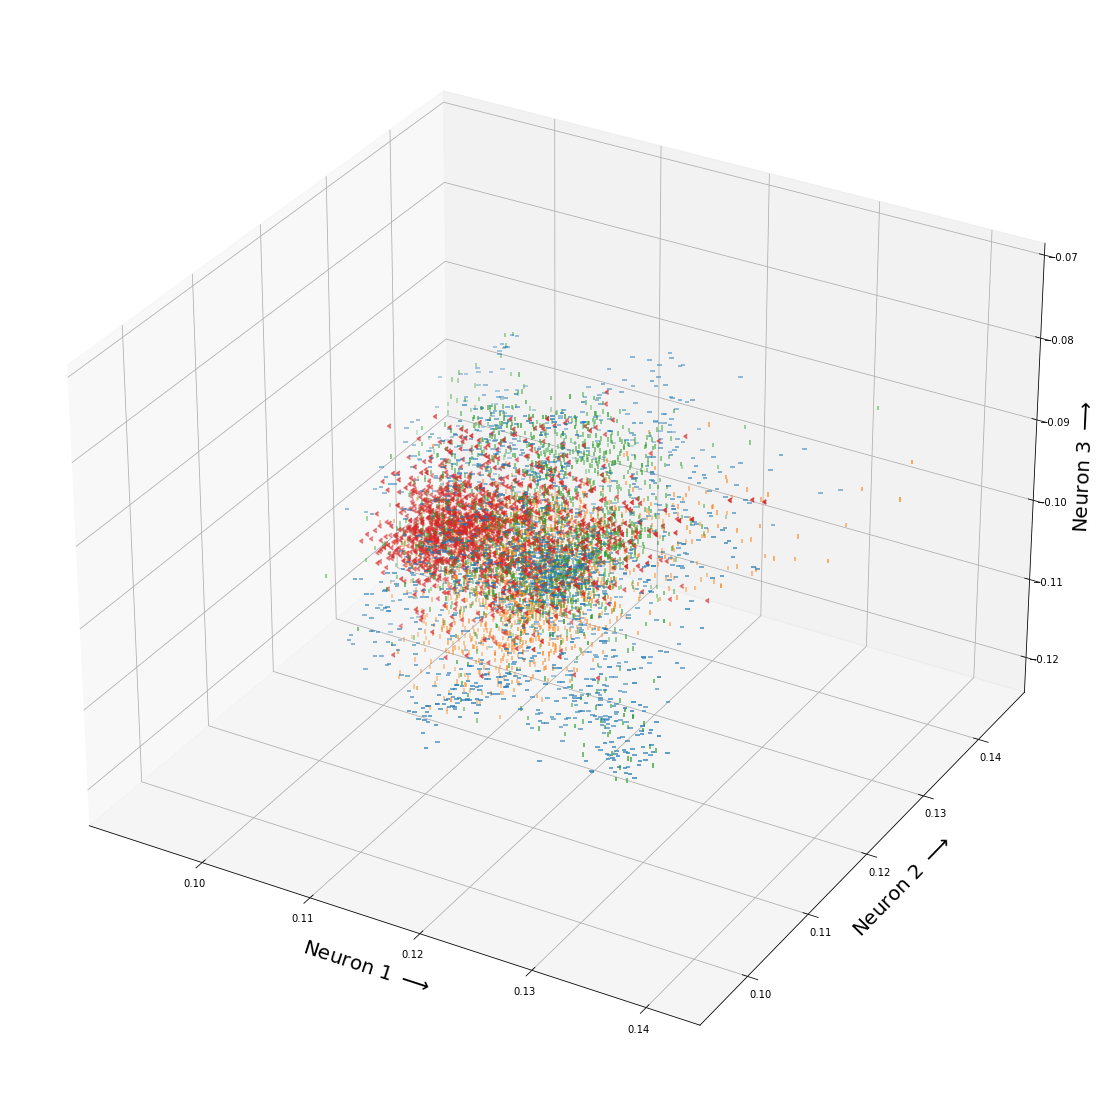

Epoch 1/10 successfull
Epoch 2/10 successfull


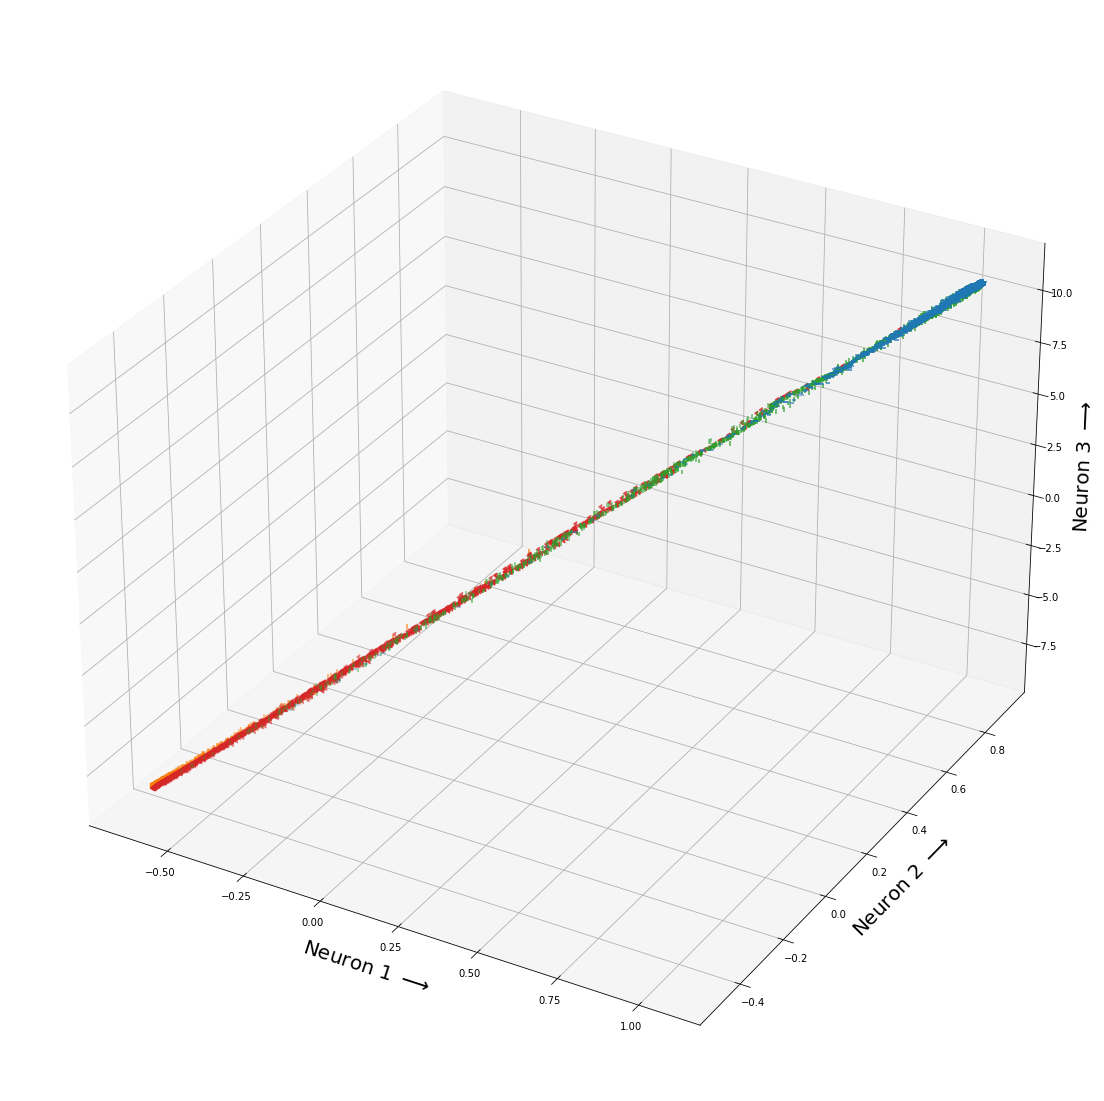

Epoch 3/10 successfull
Epoch 4/10 successfull


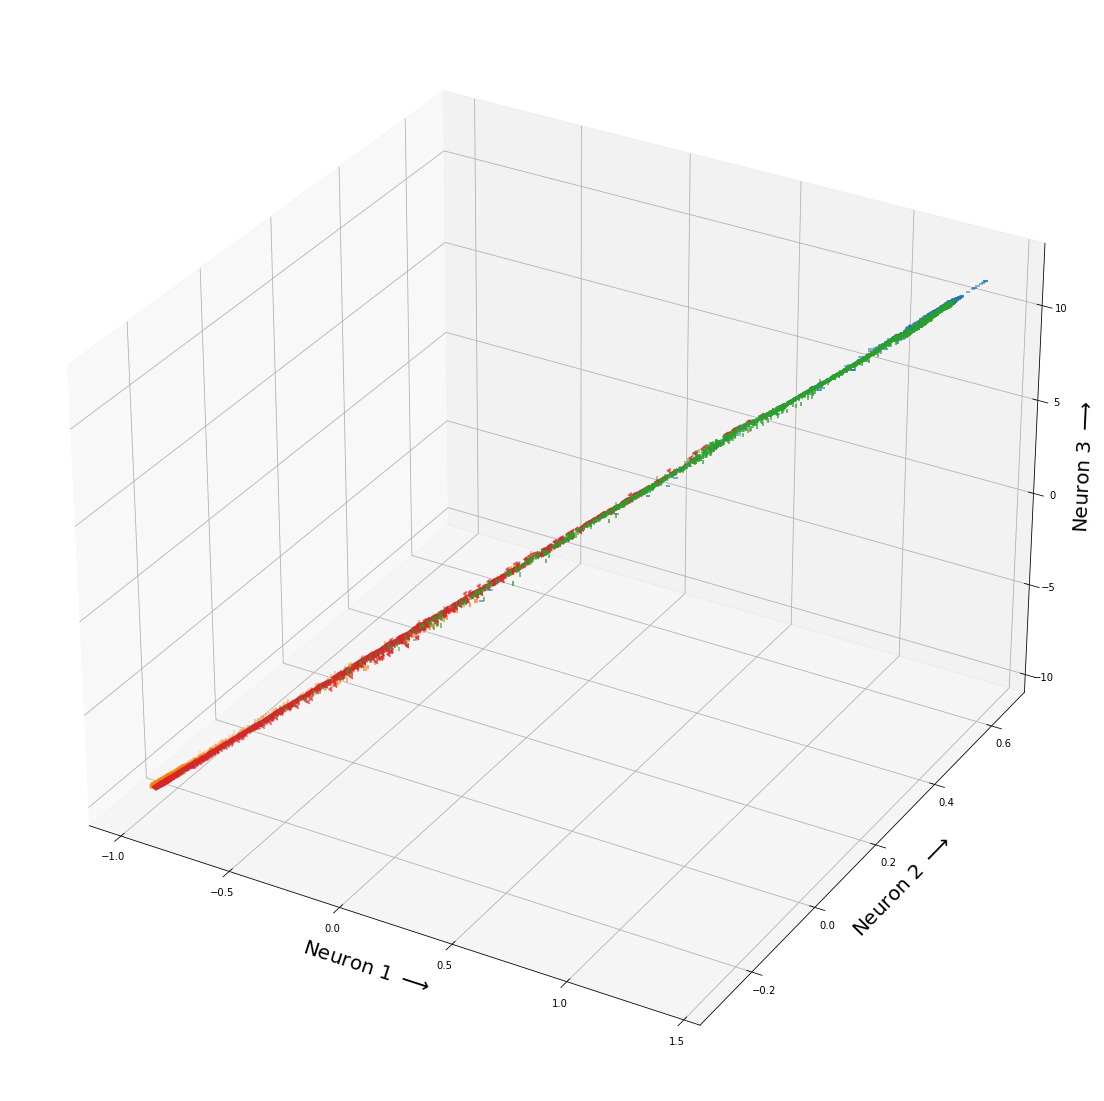

Epoch 5/10 successfull
Epoch 6/10 successfull


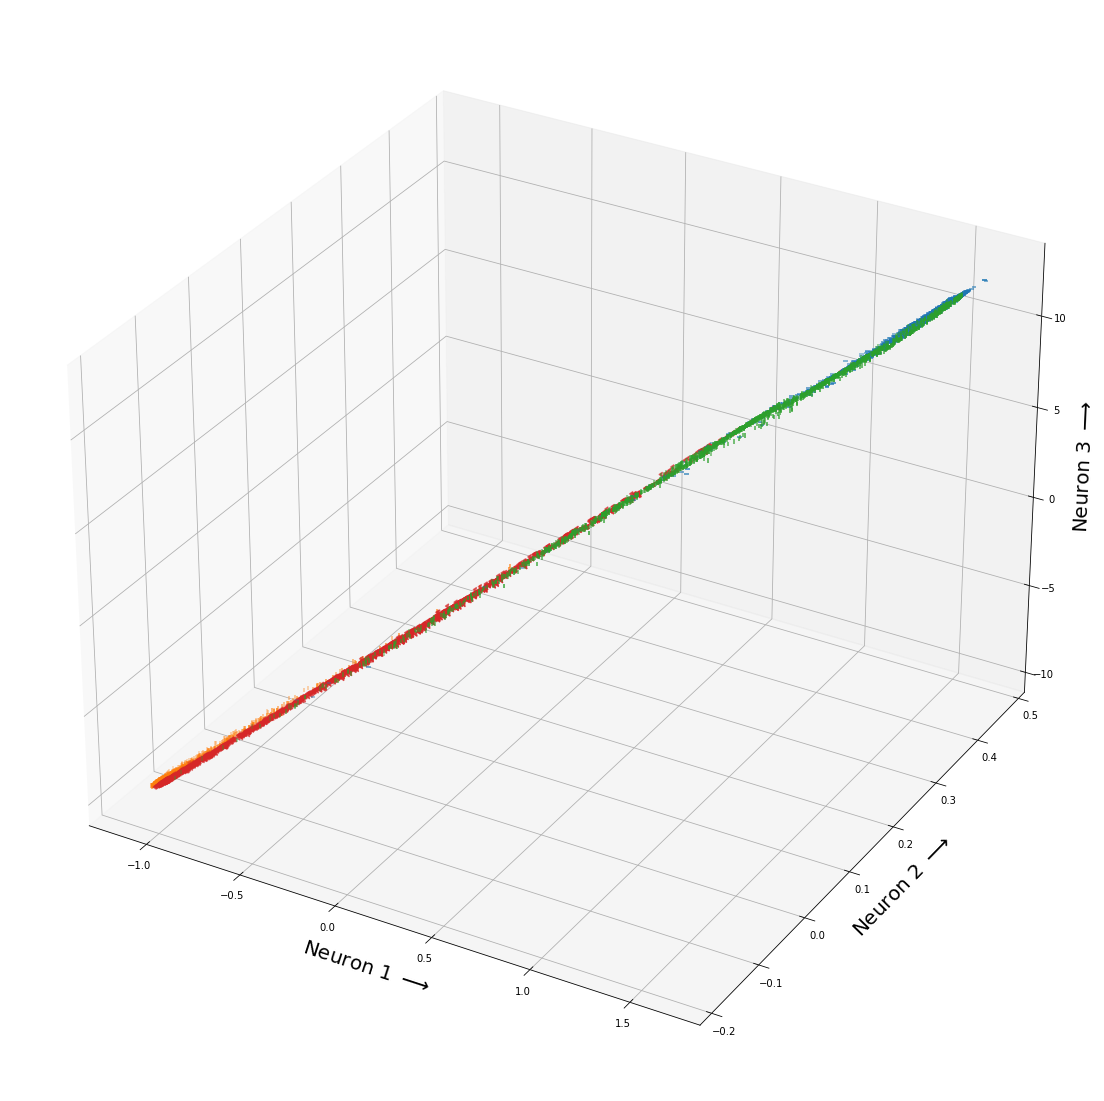

Epoch 7/10 successfull
Epoch 8/10 successfull
Epoch 9/10 successfull
Epoch 10/10 successfull


In [18]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_source_val = SummaryWriter('runs/Dataloader2/source_val')
writer_source_mmd = SummaryWriter('runs/Dataloader2/source_mmd')
writer_source_ce = SummaryWriter('runs/Dataloader2/source_ce')
writer_target_val = SummaryWriter('runs/Dataloader2/target_val')
writer_target_mmd = SummaryWriter('runs/Dataloader2/target_mmd')
writer_target_ce = SummaryWriter('runs/Dataloader2/target_ce')

writer_source = {}
writer_source["val"] = writer_source_val
writer_source["mmd"] = writer_source_mmd
writer_source["ce"] = writer_source_ce

writer_target = {}
writer_target["val"] = writer_target_val
writer_target["mmd"] = writer_target_mmd
writer_target["ce"] = writer_target_ce


#define training params
num_epochs = 10
GAMMA = 0.1
SIGMA = torch.tensor([1,2,4,8,16],dtype=torch.float64)

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss_calculator = MMD_loss(fix_sigma = SIGMA)


optimizer1 = torch.optim.Adam([
{'params': model_cnn.parameters()},
{'params': model_fc.parameters(), 'lr': 1e-4}
], lr=1e-2, betas=(0.9, 0.999))

optimizer2 = torch.optim.Adam(model_fc.parameters(), lr=1e-2, betas=(0.9, 0.999))


#training iterations
phases = ["val", "mmd", "ce"]

#mmd_loss_flag
MMD_loss_flag = {}
MMD_loss_flag["val"] = True
MMD_loss_flag["mmd"] = True
MMD_loss_flag["ce"] = False


#init train data for each batch
loss_collected = 0
source_ce_loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
acc_total_source_collected = 0
acc_total_target_collected = 0

#plot lists
mmd_loss_list = {}
mmd_loss_list['val']=[]
mmd_loss_list['mmd']=[]
mmd_loss_list['ce'] = []

ce_loss_list_source = {}
ce_loss_list_source['val']=[]
ce_loss_list_source['mmd']=[]
ce_loss_list_source['ce'] = []

ce_loss_list_target = {}
ce_loss_list_target['val']=[]
ce_loss_list_target['mmd']=[]
ce_loss_list_target['ce'] = []

accuracy_list_source = {}
accuracy_list_source['val']=[]
accuracy_list_source['mmd']=[]
accuracy_list_source['ce'] = []

accuracy_list_target = {}
accuracy_list_target['val']=[]
accuracy_list_target['mmd']=[]
accuracy_list_target['ce'] = []

# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))

    
    for phase in phases:
        iter_loader_source = iter(source_loader[phase])
        iter_loader_target = iter(target_loader[phase])
        for i in range(len(iter_loader_source)):
            
            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows
            
            
            if phase == "val":
                
                #no training
                model_cnn.train(False)
                model_fc.train(False)
                
                
                with torch.no_grad():
                    _, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward_mmd(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag[phase], GAMMA)
                    
                    # collect latent features for plot 
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "mmd":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward_mmd(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag[phase], GAMMA)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer1.zero_grad()
                loss.backward()
                optimizer1.step()
                
            elif phase == "ce":
                
                #training
                model_cnn.train(True)
                model_fc.train(True)
                
                ########Forward pass########
                loss, mmd_loss, source_ce_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward_mmd(model_cnn, model_fc, data, labels_source, labels_target, criterion, MMD_loss_calculator, MMD_loss_flag[phase], GAMMA)
                
                mmd_loss = mmd_loss.detach()
                source_ce_loss = source_ce_loss.detach()
                target_ce_loss = target_ce_loss.detach()
                ########Backward pass########
                optimizer1.zero_grad()
                loss.backward()
                optimizer1.step()
            
            # collect train data for each train phase
            mmd_loss_collected += mmd_loss
            source_ce_loss_collected += source_ce_loss
            target_ce_loss_collected += target_ce_loss
            acc_total_source_collected += acc_total_source
            acc_total_target_collected += acc_total_target
            
            
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            data_label = ["Source: Class 0", "Source: Class 1", "Target: Class 0", "Target: Class 1"]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i], label=data_label[i])
            
            
            b = open(f'{epoch}_distribution.csv', 'w')
            a = csv.writer(b)
            a.writerows(data)
            b.close()

            
            
            ax.set_xlabel('Neuron 1 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            ax.set_ylabel('Neuron 2 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            ax.set_zlabel('Neuron 3 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            
            
            
            plt.rcParams.update({'font.size': 10})
            
            plt.show()
            fig.savefig(f"no_mmd_epoch{epoch}", format='pdf')       
                          

        
        # Normalize collected train data for each train phase
        running_mmd_loss = mmd_loss_collected / len(source_loader[phase])
        
        running_acc_source = acc_total_source_collected / len(source_loader[phase])
        running_acc_target = acc_total_target_collected / len(target_loader[phase])
        
        running_source_ce_loss = source_ce_loss_collected / len(source_loader[phase])
        running_target_ce_loss = target_ce_loss_collected / len(target_loader[phase])
        
        
        #Add train data to plot list
        accuracy_list_source[phase].append(running_acc_source)
        accuracy_list_target[phase].append(running_acc_target)
        
        ce_loss_list_source[phase].append(running_source_ce_loss)
        ce_loss_list_target[phase].append(running_target_ce_loss)
        
        mmd_loss_list[phase].append(running_mmd_loss)


        #Add train data to tensorflow list
        writer_source[phase].add_scalar(f'accuracy', running_acc_source, epoch)
        writer_target[phase].add_scalar(f'accuracy', running_acc_target, epoch)
        
        writer_source[phase].add_scalar(f'ce_loss', running_source_ce_loss, epoch)
        writer_target[phase].add_scalar(f'ce_loss', running_target_ce_loss, epoch)
        
        writer_source[phase].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
        

        #reset train data for each batch
        loss_collected = 0
        source_ce_loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




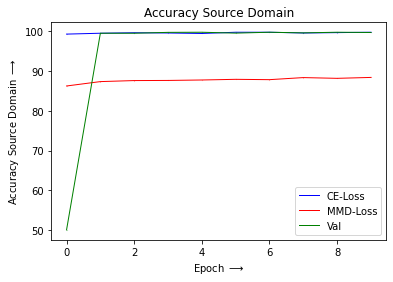

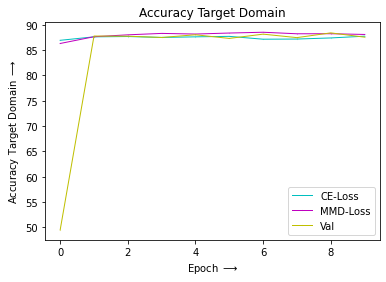

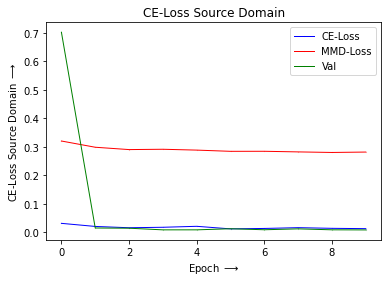

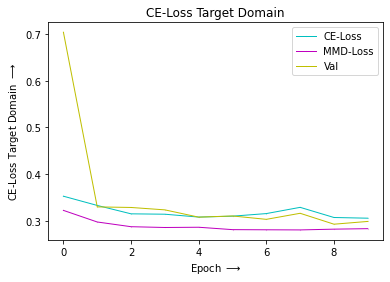

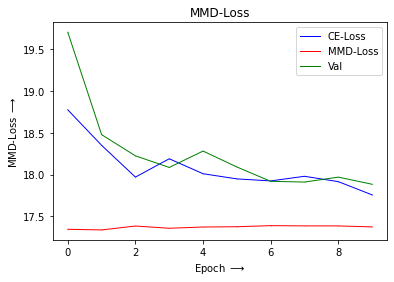

In [24]:
fig1 = plt.figure()
plt.title('Accuracy Source Domain')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.xlabel("Epoch $\longrightarrow$")
plt.ylabel("Accuracy Source Domain $\longrightarrow$")
plt.legend()
plt.show()
pd.DataFrame(accuracy_list_source['ce']).to_csv('accuracy_list_source_ce.csv',index=False,header=False)
pd.DataFrame(accuracy_list_source['mmd']).to_csv('accuracy_list_source_mmd.csv',index=False,header=False)
pd.DataFrame(accuracy_list_source['val']).to_csv('accuracy_list_source_val.csv',index=False,header=False)
fig1.savefig('Accuracy Source Domain', format='pdf')

fig2 = plt.figure()
plt.title('Accuracy Target Domain')
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.xlabel("Epoch $\longrightarrow$")
plt.ylabel("Accuracy Target Domain $\longrightarrow$")
plt.legend()
plt.show()
pd.DataFrame(accuracy_list_target['ce']).to_csv('accuracy_list_target_ce.csv',index=False,header=False)
pd.DataFrame(accuracy_list_target['mmd']).to_csv('accuracy_list_target_mmd.csv',index=False,header=False)
pd.DataFrame(accuracy_list_target['val']).to_csv('accuracy_list_target_val.csv',index=False,header=False)
fig2.savefig('Accuracy Target Domain', format='pdf')

fig3 = plt.figure()
plt.title('CE-Loss Source Domain')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.xlabel("Epoch $\longrightarrow$")
plt.ylabel("CE-Loss Source Domain $\longrightarrow$")
plt.legend()
plt.show()
pd.DataFrame(ce_loss_list_source['ce']).to_csv('ce_loss_list_source_ce.csv',index=False,header=False)
pd.DataFrame(ce_loss_list_source['mmd']).to_csv('ce_loss_list_source_mmd.csv',index=False,header=False)
pd.DataFrame(ce_loss_list_source['val']).to_csv('ce_loss_list_source_val.csv',index=False,header=False)
fig3.savefig('CE_Loss Source Domain', format='pdf')

fig4 = plt.figure()
plt.title('CE-Loss Target Domain')
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val', linewidth=1,markersize=0.1)
plt.xlabel("Epoch $\longrightarrow$")
plt.ylabel("CE-Loss Target Domain $\longrightarrow$")
plt.legend()
plt.show()
pd.DataFrame(ce_loss_list_target['ce']).to_csv('ce_loss_list_target_ce.csv',index=False,header=False)
pd.DataFrame(ce_loss_list_target['mmd']).to_csv('ce_loss_list_target_mmd.csv',index=False,header=False)
pd.DataFrame(ce_loss_list_target['val']).to_csv('ce_loss_list_target_val.csv',index=False,header=False)
fig4.savefig('CE_Loss Target Domain', format='pdf')

fig5 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.xlabel("Epoch $\longrightarrow$")
plt.ylabel("MMD-Loss $\longrightarrow$")
plt.legend()
plt.show()
pd.DataFrame(mmd_loss_list['ce']).to_csv('mmd_loss_list_ce.csv',index=False,header=False)
pd.DataFrame(mmd_loss_list['mmd']).to_csv('mmd_loss_list_mmd.csv',index=False,header=False)
pd.DataFrame(mmd_loss_list['val']).to_csv('mmd_loss_list_val.csv',index=False,header=False)
fig5.savefig('MMD_Loss', format='pdf')

In [ ]:
fig1 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['mmd'], 'ro-', label = 'MMD-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['ce'], 'co-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['mmd'], 'mo-', label = 'MMD-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(accuracy_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('Accuracy')

fig2= plt.figure()
plt.title('CE-Loss')
plt.plot(ce_loss_list_source['ce'], 'bo-', label = 'CE-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['mmd'], 'ro-', label = 'MMD-Loss-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_source['val'], 'go-', label = 'Val-Source', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['ce'], 'co-', label = 'CE-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['mmd'], 'mo-', label = 'MMD-Loss-Target', linewidth=1,markersize=0.1)
plt.plot(ce_loss_list_target['val'], 'yo-', label = 'Val-Target', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('CE_Loss')

fig3 = plt.figure()
plt.title('MMD-Loss')
plt.plot(mmd_loss_list['ce'], 'bo-', label = 'CE-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['mmd'], 'ro-', label = 'MMD-Loss', linewidth=1,markersize=0.1)
plt.plot(mmd_loss_list['val'], 'go-', label = 'Val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig3.savefig('MMD_Loss')

